<a href="https://colab.research.google.com/github/ldawes8/thinkful_work/blob/master/Take_Home_Exam_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import Libraries 
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from collections import Counter
import re
import spacy

%matplotlib inline
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle

#import gensim
#from gensim import corpora, models, similarities
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

**IMPORT DATA**

In [118]:
#Import File
from google.colab import files
uploaded = files.upload()

Saving take_homecustomers_data.csv to take_homecustomers_data (3).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['take_homecustomers_data.csv']), header=0)
colnames = ['drop', 'purch_amt', 'gender', 'card_on_file', 'age', 'days_since_last_purch', 'loyalty']
df.columns=colnames

**DATA EXPLORATION - INITIAL**

In [120]:
#Take an initial look at the data
df.head()

,drop,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


In [121]:
#Take an initial look at the shape of the data 
print(df.shape)

(120000, 7)


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
drop                     120000 non-null int64
purch_amt                120000 non-null float64
gender                   120000 non-null object
card_on_file             120000 non-null object
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 5.6+ MB


In [123]:
# Count of missing values
print (df.isnull().sum())
print('The dataset has no null values!')

drop                     0
purch_amt                0
gender                   0
card_on_file             0
age                      0
days_since_last_purch    0
loyalty                  0
dtype: int64
The dataset has no null values!


**DATA CLEANING**

In [0]:
#Drop the unnecessary columns
df = df.drop(columns = ['drop'])

In [0]:
#Convert Gender and Card_on_file to binary values 
df['gender'] = df['gender'].map({'male':1,'female':0})
df['card_on_file'] = df['card_on_file'].map({'yes':1,'no':0})

In [0]:
#Converting the loyalty column (dependent/target variable) to a categorical 
#column 
df["loyalty"] = df['loyalty'].astype('category')

In [127]:
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,1,0,31.0,35.0,False
1,65.16,1,1,23.0,61.0,False
2,40.60,0,0,36.0,49.0,False
3,38.01,1,1,47.0,57.0,False
4,22.32,0,1,5.0,39.0,False


**DATA EXPLORATION - POST CLEANING**

In [128]:
#Let's see how many customers are considered "loyal"
print(df['loyalty'].value_counts())
print('There are a total of 120,000 customers - only 20,000 are considered "loyal"')

False    100000
True      20000
Name: loyalty, dtype: int64
There are a total of 120,000 customers - only 20,000 are considered "loyal"


In [129]:
#Let's assess the male/female split"
print(df['gender'].value_counts())
print('There are 362 more males in the dataset')

1    60181
0    59819
Name: gender, dtype: int64
There are 362 more males in the dataset


In [130]:
#Let's assess the male/female split"
print(df['card_on_file'].value_counts())
print('It is pretty much a 50:50 split between customers with a card on file vs. customers without a card on file')

1    60087
0    59913
Name: card_on_file, dtype: int64
It is pretty much a 50:50 split between customers with a card on file vs. customers without a card on file


In [131]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
purch_amt,120000.0,44.036234,20.473148,-43.95,30.21,43.97,57.83,142.2
gender,120000.0,0.501508,0.500000,0.00,0.00,1.00,1.00,1.0
card_on_file,120000.0,0.500725,0.500002,0.00,0.00,1.00,1.00,1.0
age,120000.0,25.803008,10.153072,-22.00,19.00,26.00,33.00,71.0
days_since_last_purch,120000.0,56.605908,16.422187,-9.00,45.00,57.00,68.00,125.0


* The average purchase amount is $44. 
* The average age of the customers is ~26 years of age.
* The average days since last purchase is ~57. 





In [132]:
#Taking a deeper look at what makes a customer "loyal"
loyal_df = df[df['loyalty']== True]
print(loyal_df)

        purch_amt  gender  card_on_file   age  days_since_last_purch loyalty
9           93.63       0             0  40.0                   47.0    True
13          64.91       1             1  22.0                   59.0    True
23          11.55       1             0  21.0                   53.0    True
28          40.64       0             0  20.0                   29.0    True
35          64.07       1             0  10.0                   62.0    True
40          26.35       0             0  39.0                   39.0    True
48          99.03       1             0  39.0                   51.0    True
57          58.56       1             1  35.0                   37.0    True
59          53.40       0             1  37.0                   22.0    True
62          57.56       0             1  34.0                   52.0    True
63          52.23       0             1  41.0                   30.0    True
65          38.83       0             1  27.0                   46.0    True

In [133]:
#Let's assess the male/female split of "loyal customers"
print(loyal_df['gender'].value_counts())
print('There are 186 more "loyal" males in the dataset')

1    10093
0     9907
Name: gender, dtype: int64
There are 186 more "loyal" males in the dataset


In [134]:
#Let's assess the male/female split of "loyal customers"
print(loyal_df['card_on_file'].value_counts())
print('It is pretty much a 50:50 split between loyal customers with a card on file vs. customers without a card on file')

1    10003
0     9997
Name: card_on_file, dtype: int64
It is pretty much a 50:50 split between loyal customers with a card on file vs. customers without a card on file


In [135]:
loyal_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
purch_amt,20000.0,53.933842,20.072442,-28.83,40.45,54.17,67.4125,142.2
gender,20000.0,0.504650,0.499991,0.00,0.00,1.00,1.0000,1.0
card_on_file,20000.0,0.500150,0.500012,0.00,0.00,1.00,1.0000,1.0
age,20000.0,29.890900,10.037736,-12.00,23.00,30.00,37.0000,71.0
days_since_last_purch,20000.0,39.824000,12.539896,-9.00,31.00,40.00,48.0000,87.0


As expected, "loyal" customers seem to be slightly older, spend more per purchase and have less days since the last purchas,e as compared to there "non-loyal" counterparts. 

**FEATURE ENGINEEERING**

I can possibly create some new features here included age categories and purchase amounts but I do not think it will  be that helpful given the above information. 

**SUPERVISED LEARNING - CLASSIFICATION**

This is a classification problem. As a result, I will use a randome forrest classifier to predict which customers are loyal. Once the model has been trained and tested I will extract the most important features to determine what type of customers will join a loyalty program. 

In [0]:
#Convert Loyalty to a binary problem for easy modeling
df['loyalty'] = df['loyalty'].map({True:1, False:0})

In [142]:
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,1,0,31.0,35.0,0
1,65.16,1,1,23.0,61.0,0
2,40.60,0,0,36.0,49.0,0
3,38.01,1,1,47.0,57.0,0
4,22.32,0,1,5.0,39.0,0


In [0]:
#Define X and Y 
Y = df.loyalty                       
list = ['loyalty']
X= df.drop(list,axis = 1 ) #x is our set of features 

In [0]:
# Train, test, split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .30, 
                                                        random_state= 0)

In [145]:
# Examine shape of data sets
print('Training size:', x_train.shape, y_train.shape)
print('Test size:', x_test.shape, y_test.shape)

Training size: (84000, 5) (84000,)
Test size: (36000, 5) (36000,)


In [146]:
#MODEL #1 Random Forrest 
rfc = ensemble.RandomForestClassifier()  #If I had more time I could use gridsearch for hyperparameter tuning

fit = rfc.fit(x_train, y_train)
y_pred= rfc.predict(x_test)

print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9848214285714286

Test set score: 0.8485277777777778


The model seems to overfit but overal the scores are pretty good. Let's use cross validation to see if that is the case. 

In [147]:
from sklearn.model_selection import cross_val_score
cross_val_score(rfc, X, Y, cv=5)

array([0.84791667, 0.84358333, 0.84704167, 0.84970833, 0.848     ])

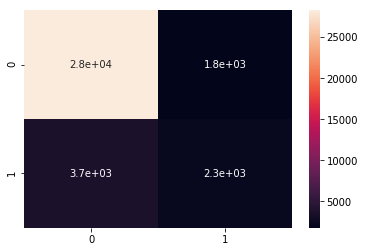

In [152]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

In [154]:
#Find the most important features from the rfc 

# Create a list of feature names
feat_labels = ['purch_amt',	'gender',	'card_on_file',	'age',	'days_since_last_purch']

# Print the name and gini importance of each feature
for feature in zip(feat_labels, rfc.feature_importances_):
    print(feature)

('purch_amt', 0.41716713190339066)
('gender', 0.01798590080719672)
('card_on_file', 0.017608860108738984)
('age', 0.17599407209984644)
('days_since_last_purch', 0.37124403508082715)


The purchase amount and days since last purchase are our most important features when it comes to predicted if a customer is "loyal". 


In [0]:
# MODEL 2 RFC - Important Features 
# Run the model with only the important features 

#Redefine X and Y 

Y = df.loyalty                       
list_imp = ['loyalty', 'gender', 'age', 'card_on_file']

x_imp = df.drop(list_imp, axis = 1 ) #x is our set of features 

y_imp = df.loyalty 

In [0]:
# Train, test, split
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(x_imp,y_imp, test_size = .30, 
                                                        random_state= 0)

In [157]:
fit2 = rfc.fit(x2_train, y2_train)
y_pred2= rfc.predict(x2_test)

print('Training set score:', rfc.score(x2_train, y2_train))
print('\nTest set score:', rfc.score(x2_test, y2_test))

Training set score: 0.9656190476190476

Test set score: 0.8168055555555556


In [158]:
from sklearn.model_selection import cross_val_score
cross_val_score(rfc, x_imp, y_imp, cv=5)

array([0.81658333, 0.81641667, 0.81758333, 0.81754167, 0.81745833])

In [151]:
# EXTRA - Other Model Types - Supervised Neural Netword 

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(x_train, y_train)
print('Training set score:', mlp.score(x_train, y_train))
print('\nTest set score:', mlp.score(x_test, y_test))

Training set score: 0.8687738095238096

Test set score: 0.8680833333333333
